# Predictive Analysis of Contraceptive Method Choices in Indonesia: An Advanced Machine Learning Approach

In [215]:
# All libraries imported are used within this project
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import calinski_harabasz_score

In [216]:
# reading csv files
names = pd.read_csv('contraceptive-method-choice/cmc.names', sep="\t")
df = pd.read_csv('contraceptive-method-choice/cmc.data', sep=",")

# EDA (Exploratory Data Analysis)
First, summary stastics will be generated for the numerical columns in the dataset. These will help to identify any disparities in the data, and therefore influence the extent to which the result of the clustering can be used, and in which contexts.

A heatmap will also be analysed, which will help to identify correlation between variables and potentially identify additional features that can be excluded or constructed.

In [217]:
# Rename columns
df.columns = [
    'w_age',
    'w_education',
    'h_education',
    'num_children',
    'w_religion',
    'w_working',
    'h_occupation',
    'sol_index',
    'media_exposure',
    'contraceptive_method'
]

# Generate summary statistics for select columns
features_to_describe = ['w_age', 'num_children']
df_subset = df[features_to_describe].copy()
df_subset.describe()

,w_age,num_children
count,1472.000000,1472.000000
mean,32.544158,3.261549
std,8.227027,2.359341
min,16.000000,0.000000
25%,26.000000,1.000000
50%,32.000000,3.000000
75%,39.000000,4.250000
max,49.000000,16.000000


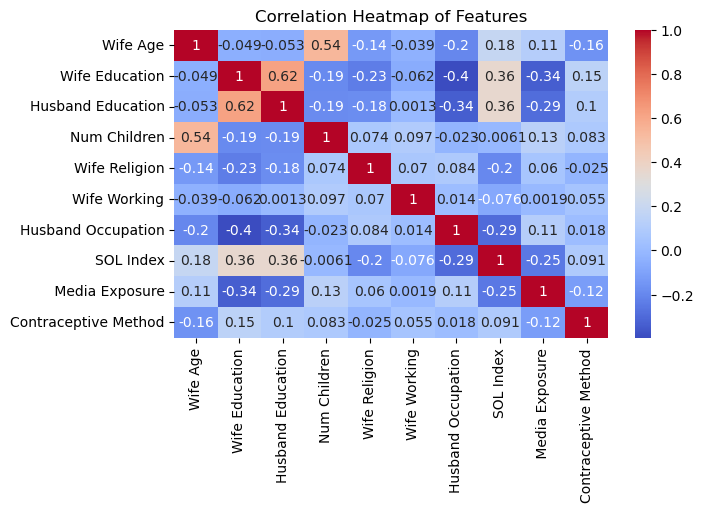

In [218]:
# Create a heatmap to show the correlation between features
feature_headings = ['Wife Age', 'Wife Education', 'Husband Education', 'Num Children', 'Wife Religion', 'Wife Working', 'Husband Occupation', 'SOL Index', ' Media Exposure', 'Contraceptive Method']

correlation_matrix = df.corr()

plt.figure(figsize=(7, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=feature_headings, yticklabels=feature_headings)
plt.title('Correlation Heatmap of Features')
plt.show()

Key Findings:
- The strong negative correlation between Wife's education and Husband's occupation indicates
- The strong negative correlation between Husband's education and Husband's occupation indicates
- The strong positive correlation between Wife's and Husband's education indicates
- The strong positive correlation between Wife's age and number of children is expected
- The strong positive correlation between standard of living index and Husband's and Wife's education indicates
- The strong positive correlation between standard of living index and Husband's occupation indicates

# Distribution of contraceptive method use
Contraceptive method use is the target variable of the clusters, so we will first visualise its distribution.

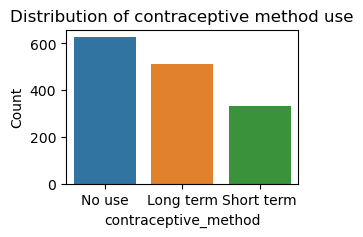

In [219]:
feature_meanings = {1: 'No use', 2: 'Long term', 3: 'Short term'}

# Create a countplot showing the distrbution of contraceptive methods
plt.figure(figsize=(3, 2))
sns.countplot(data=df, x='contraceptive_method', order=[1, 3, 2])
plt.title('Distribution of contraceptive method use')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=[feature_meanings[1], feature_meanings[2], feature_meanings[3]])
plt.show()

# Preparing Data
As categorical variables contain a clear hierarchical order, one-hot encoding is not necessary.

In [220]:
# Extract data and target
X_train = df.drop('contraceptive_method', axis=1)
y_train = df['contraceptive_method']

## Standardising Data
To account for variations in measurement units and scale, the data will be standardised using the z-score method.
\begin{align*}
z = \frac{{x - \mu}}{{\sigma}}
\end{align*}

In [221]:
# Scale features using z-score method
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
features = X_train.columns

# Update dataframe with scaled values
X_train = pd.DataFrame(X_scaled, columns=features)

In [222]:
# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=61)
X_train_copy = X_train.copy()

# K-Means: Optimising number of clusters
First, the elbow-plot method was attempted as follows. However, this produced no clear elbow plot, so an alternative approach was needed.
*Function adapted from https://www.youtube.com/watch?v=iNlZ3IU5Ffw&t=379s*

In [223]:
def discover_optimal_clusters(dataframe):
    cluster_limit = 10
    rel_distances = []
    point_means = []
    
    for i in range (1, cluster_limit):
        num_clusters = i
        kmeans = KMeans(num_clusters, n_init=10)
        kmeans.fit(dataframe)
        
        point_means.append(i)
        rel_distances.append(kmeans.inertia_)
        
    # Generate an elbow plot
    fig = plt.subplots(figsize=(10, 5))
    plt.plot(point_means, rel_distances, '-o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distances')
    plt.grid(True)
    plt.show()

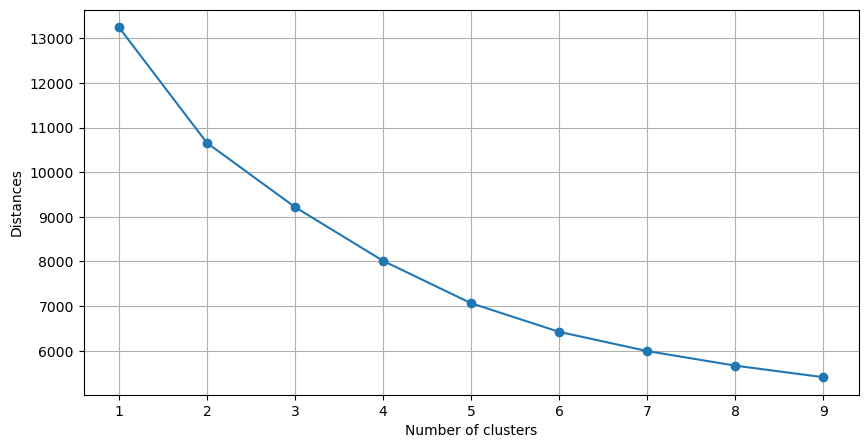

In [224]:
discover_optimal_clusters(X_train)

Then tried the silloutette plot. The number of clusters found to maximise the silloutte score was 6.

In [225]:
def discover_optimal_clusters_silhouette(dataframe):
    cluster_limit = 10
    silhouette_scores = []

    for i in range(2, cluster_limit):
        num_clusters = i
        kmeans = KMeans(num_clusters, n_init=10)
        kmeans.fit(dataframe)
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(dataframe, labels)
        silhouette_scores.append(silhouette_avg)

    # Plot the sillhouette graph to find maixmal value
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(range(2, cluster_limit), silhouette_scores, '-o')
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Silhouette Score')
    ax.grid(True)
    plt.show()

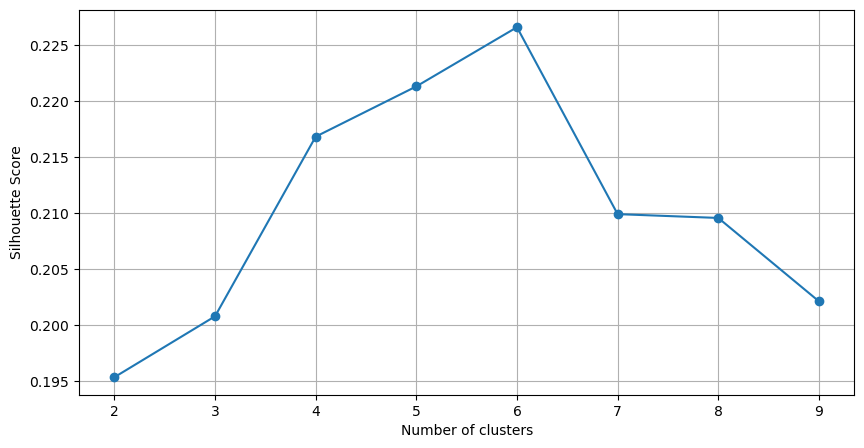

In [226]:
discover_optimal_clusters_silhouette(X_train)

In [227]:
# Perform k-means clustring on the training set
kmeans = KMeans(n_clusters=6, n_init=10, random_state=53) # 51
kmeans.fit(X_train)

# Add results to the dataset
X_train['kmeans'] = kmeans.labels_

# Perform dimensionality reduction for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

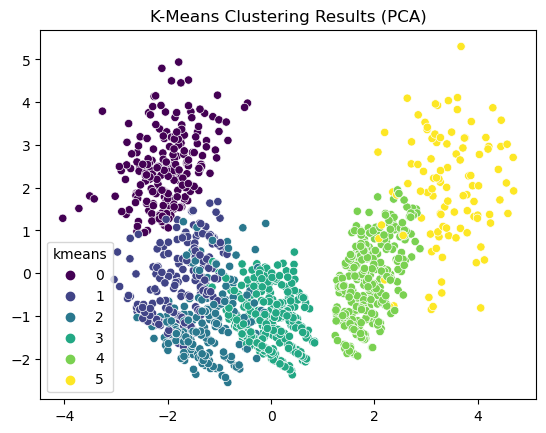

In [228]:
# Plot kmeans results using 2 principal components
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue='kmeans', data=X_train, palette='viridis')
plt.title('K-Means Clustering Results (PCA)')
plt.show()

In [229]:
# Calculate the calinski_harabasz to compre with Hierarchial clustering
cluster_labels = X_train['kmeans']
calinski_result = calinski_harabasz_score(X_train, cluster_labels)

print(f"Calinski-Harabasz Index: {calinski_result}")

Calinski-Harabasz Index: 473.82557563188334


## Interpretation of clusters

In order to interpret the clusters, we examination of how the target variable is distributed will be carried out. From there, further analysis of specific aspects of the target variable, namely contraceptive non-use and the spread of its distribution among clusters, can be calculated and visualised.

In [230]:
# Calculate the cluster centroids
clustered_data = X_train.copy()
cluster_stats = clustered_data.groupby('kmeans').agg(['mean', 'median', pd.Series.mode])

# Find out how many instances per cluster
cluster_sizes = clustered_data['kmeans'].value_counts()
print("Intances per cluster:")
print(cluster_sizes)

Intances per cluster:
kmeans
4    380
3    346
0    229
1    205
2    205
5    107
Name: count, dtype: int64


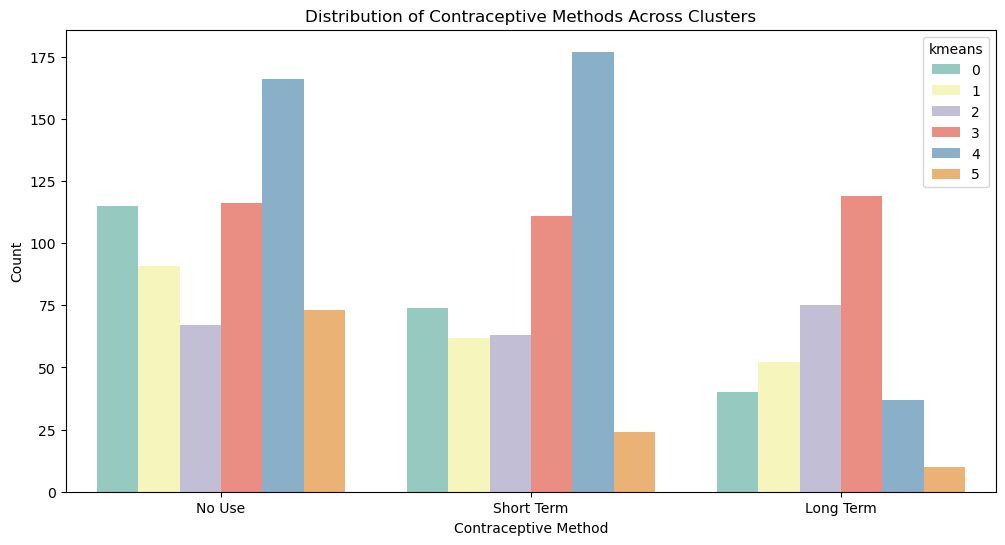

In [231]:
# Visualising Contraceptive Use Amongst Clusters
plt.figure(figsize=(12, 6))
color_palette = "Set3"
sns.countplot(x=y_train, hue='kmeans', data=X_train, palette=color_palette, order=[1, 3, 2])
plt.title('Distribution of Contraceptive Methods Across Clusters')
plt.xlabel('Contraceptive Method')
plt.xticks(ticks=[0, 1, 2], labels=["No Use", "Short Term", "Long Term"])
plt.ylabel('Count')
plt.show()

Percentage of individuals in each cluster not using contraceptives:
Cluster 1: 50%
Cluster 2: 44%
Cluster 3: 33%
Cluster 4: 34%
Cluster 5: 44%
Cluster 6: 68%


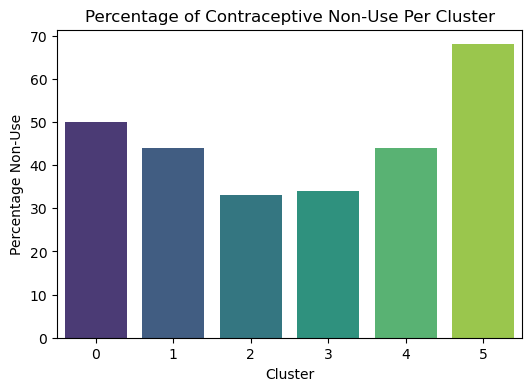

In [232]:
# Calculating percentage of contraceptive non-use in each cluster (to nearest %)

# Combine y_train and kmeans result
kmeans_clusters = pd.DataFrame({'kmeans': X_train['kmeans'], 'contraceptive_method': y_train})

# For each cluster, find the % of indivduals with y_train value 1, represnting contraceptive non use
print("Percentage of individuals in each cluster not using contraceptives:")
percentage_non_use = kmeans_clusters.groupby('kmeans')['contraceptive_method'].apply(lambda x: print(f"Cluster {x.name + 1}: {round((x == 1).sum() / len(x) * 100)}%"))

# Plot a bar chart to visualise the spread of means amongst clusters
percentage_df = kmeans_clusters.groupby('kmeans')['contraceptive_method'].apply(lambda x: round((x == 1).sum() / len(x) * 100)).reset_index()
percentage_df.columns = ['Cluster', 'Percentage Non-Use']
plt.figure(figsize=(6, 4))
sns.barplot(x='Cluster', y='Percentage Non-Use', data=percentage_df, palette='viridis')
plt.title('Percentage of Contraceptive Non-Use Per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage Non-Use')
plt.show()

## Contraceptive Use Amongst Clusters
- Highest concern: clusters 3, 0 and 1. These rarely use contraceptive methods.
- Lowest concern: clusters 2 and 5. High proportion of individuals use contraceptives.
- Observation: cluster 4 likely to use short-term contraceptives, but rarely long term. Could include this discovery in policy reccomendation.

Modes for w_education across clusters:
kmeans
0   -0.945355
1    1.025697
2    1.025697
3    1.025697
4    0.040171
5   -1.930881
Name: mode, dtype: float64


Modes for h_education across clusters:
kmeans
0   -0.526819
1    0.698264
2    0.698264
3    0.698264
4    0.698264
5   -1.751901
Name: mode, dtype: float64


Modes for h_occupation across clusters:
kmeans
0    0.996812
1   -1.315729
2   -0.159458
3   -1.315729
4    0.996812
5    0.996812
Name: mode, dtype: float64


Modes for sol_index across clusters:
kmeans
0   -0.137101
1    0.887327
2    0.887327
3    0.887327
4   -0.137101
5   -1.161529
Name: mode, dtype: float64




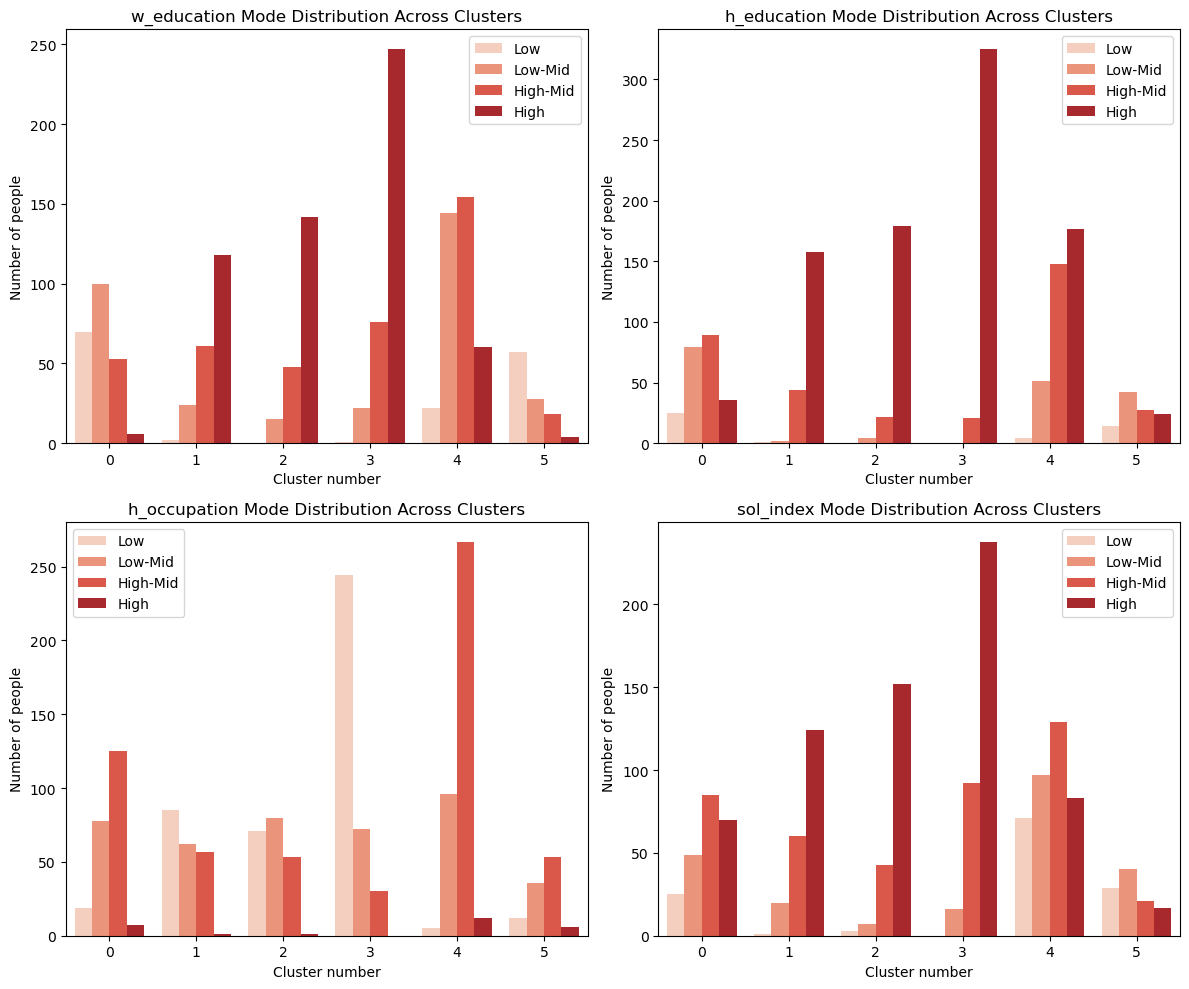

In [233]:
# Intepreting modes of categorical and binary features
categorical_cols = [1, 2, 6, 7]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
color_palette = "Reds"

# Plot modes of cateogrical columns
for i, place in enumerate(categorical_cols):
    stat = clustered_data.columns[place]
    modes = cluster_stats[stat]['mode']
    print(f'Modes for {stat} across clusters:')
    print(modes)
    print('\n')

    # Create bar chart
    row = i // 2
    col = i % 2
    sns.countplot(x='kmeans', hue=stat, data=clustered_data, ax=axes[row, col], palette=color_palette)
    axes[row, col].set_title(f'{stat} Mode Distribution Across Clusters')
    axes[row, col].legend(labels=['Low', 'Low-Mid', 'High-Mid', 'High'])
    axes[row, col].set_ylabel('Number of people')
    axes[row, col].set_xlabel('Cluster number')

plt.tight_layout()
plt.show()

## Analysis of Clusters Across Categories

Summary: 
- Highest standard of living in cluster 2, with 5, 1 and 4 closely following
- Wife and Husband's education level increases with standard of living
- Husband's occupation has limited correlation with standard of living
- These patterns align closely with analysis of contraceptive use above

Conclusion: Standard of living has a direct impact on likelihood of contraceptive non-use. Increased education for both partners equates to an increase in standard of living, and hence contraceptive use.

Interestingly, the clusters suggest that as the husband's occupation level goes up, the likelihood of contraceptive non-use goes up with it. This may suggest that poorer family's are receving adequate support already with family planning, with the upper class potentially getting neglected.

Cluster 4, which primarily uses short-term contraceptives, consists mainly of middle class familes. This could suggest that middle class familes have access to contraceptives in the short term, but don't often consider the long term benefits of using it.

Means of w_age across clusters:
kmeans
0    0.719138
1   -0.027018
2    0.340130
3    0.229732
4   -0.920828
5    0.388384
Name: mean, dtype: float64


Means of num_children across clusters:
kmeans
0    1.138862
1   -0.342538
2   -0.203966
3    0.025126
4   -0.550506
5    0.483486
Name: mean, dtype: float64




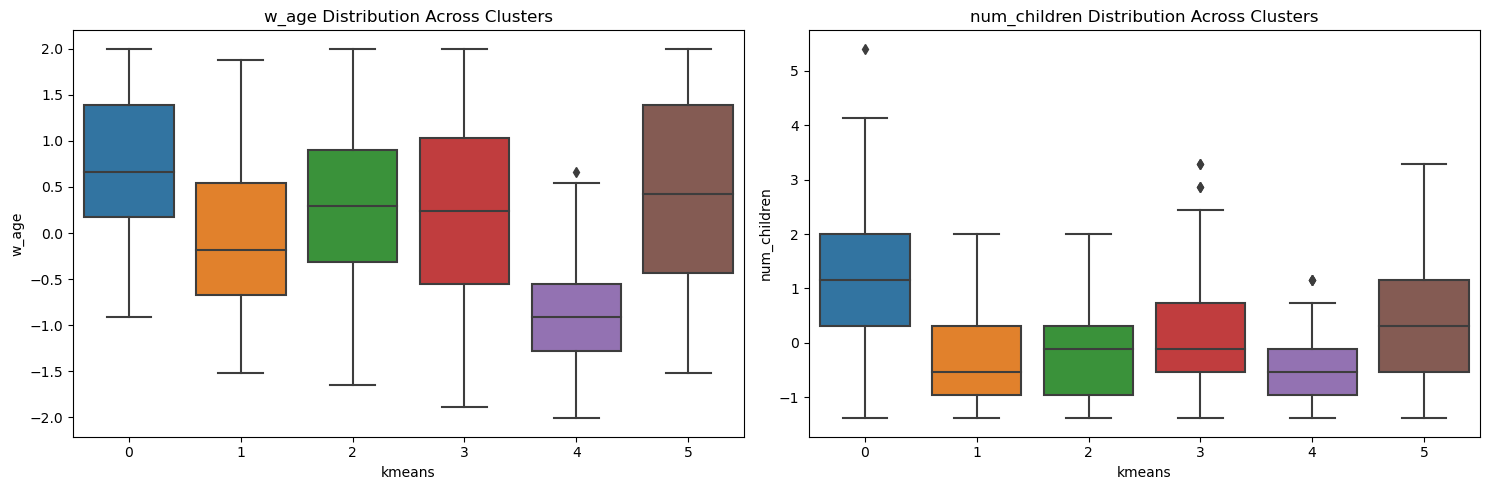

In [234]:
# Interpreting means of numerical columns
numerical_cols = [0, 3]
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_cols), figsize=(15,5))

# Plot mean stats for each numerical feature
for place in numerical_cols:
    stat = clustered_data.columns[place]
    means = cluster_stats[stat]['mean']
    print(f"Means of {stat} across clusters:")
    print(means)
    print("\n")


# Loop through each column and create a box plot for each cluster
for i, place in enumerate(numerical_cols):
    stat = clustered_data.columns[place]
    sns.boxplot(x='kmeans', y=stat, data=clustered_data, ax=axes[i])
    axes[i].set_title(f'{stat} Distribution Across Clusters')

# Adjust layout
plt.tight_layout()
plt.show()

# Hierarchial Clustering
## Primary Approach: Euclidean Distance

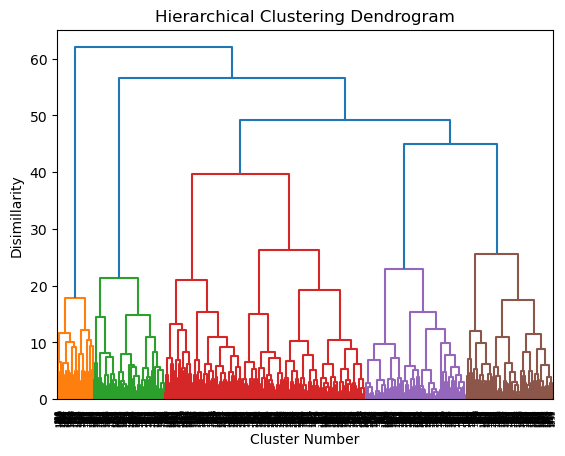

Cophenetic Correlation Coefficient: 0.6308068818335477


In [235]:
# Performing heirarchail clustering with eucdlien distance
matrix_euclidean = pdist(X_train_copy, metric='euclidean')
linkage_matrix_euc = linkage(matrix_euclidean, method='ward')

# Visualise in dendrogram
dendrogram(linkage_matrix_euc)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Number')
plt.ylabel('Disimillarity')
plt.show()

c, _ = cophenet(linkage_matrix_euc, pdist(X_train_copy))
print(f'Cophenetic Correlation Coefficient: {c}')

## Secondary Approach: Gower Distance

With the intention of finding more distinct groups in the dendrogram, a new approach using Gower Distance was explored. Gower Distance has been indentified as a strong choice for this due to its ability to effectivley cluster mixed data in many cases.

In [236]:
# First, Gower distance matrix calcuation is perfomed
matrix_gower = pairwise_distances(X_train_copy, metric='manhattan')

# This is followed by the heirarchial clustering using gower distance
matrix_reduce = squareform(matrix_gower)
linkage_matrix_gow = linkage(matrix_reduce, method='ward')

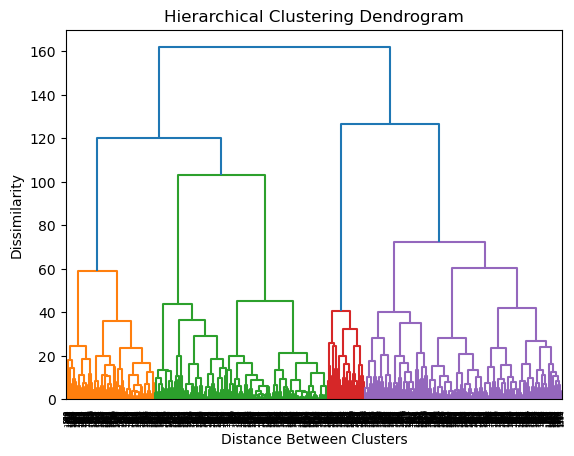

Cophenetic Correlation Coefficient: 0.4713676196251433


In [237]:
# The dendrogram represnting the heirarchy of clusters is plot
dendrogram(linkage_matrix_gow)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Distance Between Clusters')
plt.ylabel('Dissimilarity')
plt.show()

c, _ = cophenet(linkage_matrix_gow, pdist(X_train_copy))
print(f'Cophenetic Correlation Coefficient: {c}')

# Cluster Interpretation
Upon examining the dendrogram, four majors groups are apparent.
The first group appears to have the greatest dissimilarity of the bunch, suggesting a unique interplay between the sociodemographic features of the individuals that fall into it.

In order to investigate further, the dendrogram will be cut into four clusters and analysed in a similar way to the K-Means clusters, allowing for a more direct comparison to be drawn between the two clustering methods.


In [242]:
# Cut the dendrogram into 4 groups
num_clusters = 4
cluster_vals = fcluster(linkage_matrix_gow, num_clusters, criterion='maxclust')

# Add result of clustering to the dataset
X_train_copy['cluster_nums'] = cluster_vals

# Determne count of each cluster
cluster_counts = X_train_copy['cluster_nums'].value_counts()
print("Unique cluster number counts:")
print(cluster_counts)

Unique cluster number counts:
cluster_nums
4    585
2    513
1    265
3    109
Name: count, dtype: int64


### Footnote on intepreting clustering
Due to the Calinski-Harabasz's sensitivity to cluster size, it's important to note the disparity between differnt clusters when comparing this model with K-Means. K-Means produces more evely sized clusters, and so will therefore likely score higher due to this fact.

# Analysis of heirarchial clustering result

Percentage of individuals in each cluster not using contraceptives:
Cluster 2: 47%
Cluster 3: 33%
Cluster 4: 68%
Cluster 5: 45%


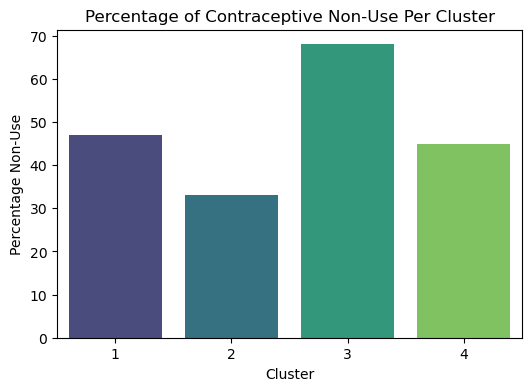

In [239]:
# Calculating percentage of contraceptive non-use in each cluster (to nearest %)
heirarchy_clusters = pd.DataFrame({'cluster_nums': X_train_copy['cluster_nums'], 'contraceptive_method': y_train})

# For each cluster, find the % of indivduals with y_train value 1, represnting contraceptive non use
print("Percentage of individuals in each cluster not using contraceptives:")
percentage_non_use = heirarchy_clusters.groupby('cluster_nums')['contraceptive_method'].apply(lambda x: print(f"Cluster {x.name + 1}: {round((x == 1).sum() / len(x) * 100)}%"))

# Plot a bar chart to visualise the spread of means amongst clusters
percentage_df = heirarchy_clusters.groupby('cluster_nums')['contraceptive_method'].apply(lambda x: round((x == 1).sum() / len(x) * 100)).reset_index()
percentage_df.columns = ['Cluster', 'Percentage Non-Use']
plt.figure(figsize=(6, 4))
sns.barplot(x='Cluster', y='Percentage Non-Use', data=percentage_df, palette='viridis')
plt.title('Percentage of Contraceptive Non-Use Per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage Non-Use')
plt.show()

In [240]:
# Calculate a calinski_harabasz score to compare with K-means
calinski_result = calinski_harabasz_score(X_train_copy, cluster_vals)
print(f"Calinski-Harabasz Index: {calinski_result}")

Calinski-Harabasz Index: 374.5988681061176
